In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES

from shmex.shm_data import pcp_df_of_non_shmoof_nickname


In [3]:
data_nickname = "shmoof"
pcp_df = pcp_df_of_non_shmoof_nickname(data_nickname)
crepe_path = "../train/trained_models/cnn_joi_lrg-shmoof_small-fixed-0"
crepe = framework.load_crepe(crepe_path)

Loading /Users/matsen/data/v0/shmoof_pcp_2023-11-30_MASKED.csv.gz


### filter rows so that we only take ones with branch length less than 0.1


In [8]:
pcp_df = pcp_df[pcp_df["branch_length"] < 0.05].reset_index(drop=True)

<Axes: xlabel='branch_length', ylabel='Proportion'>

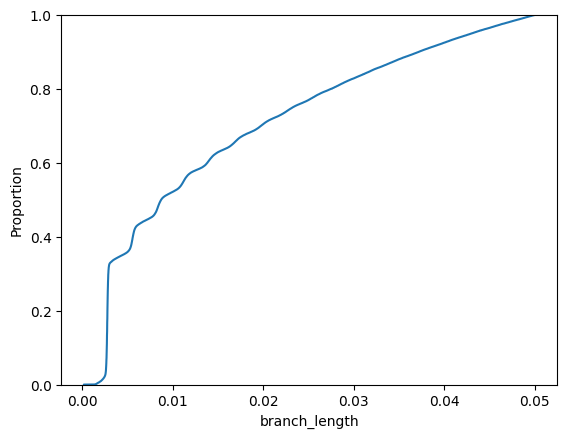

In [9]:
# plot ecdf of pcp_df["branch_length"]
sns.ecdfplot(pcp_df["branch_length"])

In [6]:
## todo: look at likelihood of a 1-hit mutation and make sure it goes up and down? 

In [10]:
import pandas as pd
import numpy as np

def count_codon_mutations(pcp_df, child_col="child"):
    # Dictionary to store total counts of mutations across all PCPs
    mutation_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    # Loop over each row in the DataFrame
    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row[child_col]
        
        for i in range(0, len(parent_seq) - 2, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            # Ensure we have complete codons
            if len(parent_codon) == 3 and len(child_codon) == 3:
                # Count mutations
                mutations = sum(1 for a, b in zip(parent_codon, child_codon) if a != b)
                mutation_counts[mutations] += 1

    return mutation_counts


# Call the function
mutation_counts = count_codon_mutations(pcp_df)
print(mutation_counts)


{0: 24104794, 1: 874854, 2: 64572, 3: 4254}


In [6]:
batch_size = 10000
mini_df = pcp_df.iloc[0:batch_size].copy().reset_index(drop=True)
ratess, csp_logitss = crepe(mini_df["parent"])

assert pcp_df["parent"].apply(len).max() <= ratess.shape[1]

#### Why are the frequencies of multinucleotide mutations so small?

In [7]:
# make alt_bases a dict that takes a base and returns the other three bases
alt_bases = {b: [a for a in BASES if a != b] for b in BASES}
alt_bases

{'A': ['C', 'G', 'T'],
 'C': ['A', 'G', 'T'],
 'G': ['A', 'C', 'T'],
 'T': ['A', 'C', 'G']}

We can see that when we simulate using the rates, that the data has many more multinucleotide mutations in codons than a simple categorical simulation. This is expected due to the clustering of mutations.

In [8]:
mini_df["mutation_count"] = [sum(1 for a, b in zip(parent, child) if a != b) for parent, child in zip(mini_df["parent"], mini_df["child"])]

# simulate a sim_child sequence which is the same as the parent sequence except for having mutation_count mutations spread according to ratess
sim_children = []
for parent, mutation_count, rates in zip(mini_df["parent"], mini_df["mutation_count"], ratess):
    child = list(parent)
    rates = rates.detach().numpy()
    # set entries of rates to 0 that have an N in the parent sequence
    for i, base in enumerate(parent):
        if base == "N":
            rates[i] = 0.
    # truncate rates to the length of parent
    rates = rates[:len(parent)]
    # normalize rates
    rates /= rates.sum()
    mutation_sites = np.random.choice(len(parent), mutation_count, p=rates, replace=False)
    for mutation_site in mutation_sites:
        child[mutation_site] = np.random.choice(alt_bases[child[mutation_site]])
    sim_children.append("".join(child))

mini_df["sim_child"] = sim_children
assert (mini_df["mutation_count"] == [sum(1 for a, b in zip(parent, child) if a != b) for parent, child in zip(mini_df["parent"], mini_df["sim_child"])]).all()

child_codon_mut_count = count_codon_mutations(mini_df, child_col="child")
sim_child_codon_mut_count = count_codon_mutations(mini_df, child_col="sim_child")
print("data", child_codon_mut_count)
print("simu", sim_child_codon_mut_count)

data {0: 1183354, 1: 22338, 2: 1262, 3: 132}
simu {0: 1182302, 1: 24320, 2: 457, 3: 7}


#### Now let's compute our moment-matched rates

In [9]:
def mmatch_2(rates):
    """Calculate the moment matching rate for a tensor of two lambda values."""
    inv_rates = 1.0 / rates
    return 1.0 / (inv_rates.sum() - 1.0 / rates.sum())

def mmatch_3(rates):
    """Calculate the moment matching rate for a tensor of three lambda values."""
    inv_rates = 1.0 / rates
    
    # Create a matrix of pairwise sums of rates
    pairwise_sums = rates.unsqueeze(0) + rates.unsqueeze(1)
    
    # Extract the lower triangle part excluding the diagonal to avoid self-pairing
    # and ensure each pair is considered only once
    lower_tri = pairwise_sums.tril(-1)
    
    # Filter out zeros and invert each pairwise sum individually
    nonzero_pairwise_sums = lower_tri[lower_tri != 0]
    inv_nonzero_pairwise_sums = 1.0 / nonzero_pairwise_sums
    
    # Sum the inverted pairwise sums
    sum_inv_pairwise_sums = inv_nonzero_pairwise_sums.sum()

    # Final moment matching calculation for three rates
    return 1.0 / (inv_rates.sum() - sum_inv_pairwise_sums + 1.0 / rates.sum())

# Test the function using:
# def lambda_est(lambda_1, lambda_2):
#    return 1 / (1/lambda_1 + 1/lambda_2 - 1/(lambda_1 + lambda_2))
def test_mmatch_3():
    rates = torch.tensor([1, 2, 3], dtype=torch.float32)
    expected_result = 0.821917808219178
    calculated_result = mmatch_3(rates)
    assert torch.isclose(calculated_result, torch.tensor(expected_result), atol=1e-6), "mmatch_3 test failed"

test_mmatch_3()

def compute_unscaled_rates(nt_rates):
    """Compute the unscaled rates tensor for codons."""
    assert nt_rates.numel() % 3 == 0, "The length of nt_rates must be a multiple of 3."
    codon_count = nt_rates.shape[0] // 3
    unscaled_rates = torch.zeros((codon_count, 3))

    # Reshape nt_rates for easier slicing
    nt_rates_reshaped = nt_rates.view(-1, 3)

    # Calculate unscaled rates
    for i in range(codon_count):
        rates = nt_rates_reshaped[i]

        # If the max of rates is 0, continue, which leaves all rates at 0.
        if rates.max() == 0.:
            continue

        # Rate for 1 mutation is simply the sum of rates
        unscaled_rates[i, 0] = rates.sum()

        # Rate for 2 mutations is the sum of mmatch_2 applied to all pairs
        unscaled_rates[i, 1] = mmatch_2(rates[:2]) + mmatch_2(torch.tensor([rates[0], rates[2]])) + mmatch_2(rates[1:])

        # Rate for 3 mutations is mmatch_3 applied to all three rates
        unscaled_rates[i, 2] = mmatch_3(rates)

    return unscaled_rates

def compute_unscaled_ratess(nt_ratess):
    """Compute the unscaled rates tensors for a batch of sequences of nt rates."""
    batch_unscaled_rates = torch.cat([compute_unscaled_rates(nt_rates).unsqueeze(0) for nt_rates in nt_ratess], dim=0)
    return batch_unscaled_rates


# Example usage
nt_rates = torch.tensor([0., 0., 0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], dtype=torch.float32)
unscaled_rates = compute_unscaled_rates(nt_rates)
print(unscaled_rates)


tensor([[0.0000, 0.0000, 0.0000],
        [0.6000, 0.3359, 0.0822],
        [1.5000, 0.9735, 0.2623]])


In [10]:
# for each sequence in mini_df, move along the triplet codons and the corresponding rates, and set the rates to 0 if the codon has an N anywhere
# also, set rates to 0 for any remaining entries that are not part of a codon
for (parent, rates) in zip(mini_df["parent"], ratess):
    for i in range(0, len(parent), 3):
        if "N" in parent[i:i+3]:
            rates[i:i+3] = 0.
    rates[3*(len(parent)//3):] = 0.

# truncate the last dimension of ratess so it's divisible by 3
if ratess.shape[1] % 3 != 0:
    ratess = ratess[:, :-(ratess.shape[1] % 3)]
unscaled_ratess = compute_unscaled_ratess(ratess)

In [11]:
unscaled_ratess[0]

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0137, 0.0050, 0.0012],
        [0.0059, 0.0032, 0.0008],
        [0.0063, 0.0038, 0.0010],
        [0.0160, 0.0099, 0.0026],
        [0.0162, 0.0103, 0.0027],
        [0.0133, 0.0084, 0.0022],
        [0.0101, 0.0062, 0.0016],
        [0.024

In [12]:
import torch

def sample_mutations_adjusted(mut_tensor, mut_count):
    """
    Sample mutations from a tensor where columns represent 1, 2, and 3 mutations,
    but ensure the total number of mutation events matches a specified count.
    
    Args:
    mut_tensor (torch.Tensor): Mutation rates tensor of shape [n_sites, 3].
    mut_count (int): Desired total number of mutations.
    
    Returns:
    torch.Tensor: Counts of sampled 1, 2, and 3 mutations.
    """
    # Flatten tensor and normalize to get probabilities. Here we are using the fact
    # that rates are proportional to probabilities.
    flattened_probs = mut_tensor.flatten()
    probabilities = flattened_probs / flattened_probs.sum()
    
    mutation_results = torch.zeros(3, dtype=torch.long)
    current_mutations = 0

    while current_mutations < mut_count:
        # Sample one index (site and mutation type)
        selected_index = torch.multinomial(probabilities, 1, replacement=False)
        selected_row, selected_col = divmod(selected_index.item(), 3)
        
        # Calculate potential new mutation count
        potential_new_mutations = current_mutations + (selected_col + 1)

        # Check if this selection exceeds the desired mutation count
        if potential_new_mutations <= mut_count:
            # Valid selection, update counts
            mutation_results[selected_col] += 1
            current_mutations = potential_new_mutations

    return mutation_results

# Example usage
mut_tensor = torch.tensor([
    [0.0000, 0.0000, 0.0000],
    [0.0137, 0.0050, 0.0012],
    [0.0059, 0.0032, 0.0008],
    [0.0063, 0.0038, 0.0010]
])
mut_count = 3
result = sample_mutations_adjusted(mut_tensor, mut_count)
print("Sampled mutation counts:", result)


Sampled mutation counts: tensor([1, 1, 0])


In [13]:
sampled_mutss = []

for unscaled_rates, mut_count in zip(unscaled_ratess, mini_df["mutation_count"]):
    sampled_muts = sample_mutations_adjusted(unscaled_rates, mut_count)
    sampled_mutss.append(sampled_muts)

sampled_mutss = torch.stack(sampled_mutss)
# sum across rows
totals = sampled_mutss.sum(dim=0)
grand_total = torch.dot(totals, torch.tensor([1, 2, 3], dtype=torch.long))
totals, grand_total, mini_df["mutation_count"].sum()

(tensor([15299,  3931,   700]), tensor(25261), 25261)

In [14]:
compare_df = pd.DataFrame([child_codon_mut_count, sim_child_codon_mut_count], index=["data", "per-nt site simulation"])
# drop column 0 from compare_df
compare_df = compare_df.drop(columns=0)
# append totals to compare_df without using the df.append method
compare_df.loc["per codon simulation"] = totals.detach().numpy()
# set total to be the dot product of each row with [1,2,3]
compare_df["total"] = np.dot(compare_df, [1, 2, 3])
compare_df

,1,2,3,total
data,22338,1262,132,25258
per-nt site simulation,24320,457,7,25255
per codon simulation,15299,3931,700,25261


In [15]:
class MultihitModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Parameters for 1, 2, and 3 mutations
        self.log_multihit_rate = nn.Parameter(torch.randn(3))
    
    def forward(self, unscaled_ratess, branch_lengths):
        """
        Compute the full probability distribution across [0, 1, 2, 3] mutations.

        Parameters:
        ----------
        unscaled_ratess : torch.Tensor
            The base mutation rate. Should have shape [batch_size, sequence_length, 3].
        branch_lengths : torch.Tensor
            The branch lengths. Should have shape [batch_size].

        Returns:
        -------
        torch.Tensor
            The full probability distribution across [0, 1, 2, 3] mutations.
            The shape of the tensor will be [batch_size, sequence_length, 4].
        """
        multihit_rate = torch.exp(self.log_multihit_rate)  # multihit_rate has shape [3]
        
        # Expand branch_lengths to match the dimensions of unscaled_ratess
        # Since unscaled_ratess includes the mutation type dimension, expand branch_lengths accordingly
        branch_lengths = branch_lengths.unsqueeze(1).expand(-1, unscaled_ratess.shape[1]).unsqueeze(-1)  # [batch_size, sequence_length, 1]

        # Braodcasting:
        # unscaled_ratess: [batch_size, sequence_length, 3]
        # multihit_rate: [3] broadcasted to [batch_size, sequence_length, 3]
        # branch_lengths: [batch_size, sequence_length, 1] broadcasted to [batch_size, sequence_length, 3]
        mutation_probs = 1 - torch.exp(-unscaled_ratess * multihit_rate * branch_lengths)

        # Probability of zero mutations is 1 minus the sum of probabilities of 1, 2, and 3 mutations
        prob_zero_mutations = 1 - torch.sum(mutation_probs, dim=2)
        
        # Clip the probabilities to ensure they are within the unit interval [0, 1]
        prob_zero_mutations = torch.clamp(prob_zero_mutations, min=0.0, max=1.0)
        
        # Stack the probabilities together: zero mutations first, then 1, 2, 3
        full_probs = torch.cat([prob_zero_mutations.unsqueeze(-1), mutation_probs], dim=2)
        
        # Return the full probability distribution across [0, 1, 2, 3] mutations
        return full_probs




In [16]:
def labels_of_pcp_df(pcp_df, codon_count):
    labels = torch.zeros((len(pcp_df), codon_count), dtype=torch.int64)

    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row['child']

        assert len(parent_seq) == len(child_seq)
        valid_length = (len(parent_seq) // 3) * 3
        
        # Check and warn if the valid codon count exceeds the codon_count parameter
        if valid_length // 3 > codon_count:
            print(f"Warning: Truncating sequences at index {index} to {codon_count} codons, though {valid_length // 3} could be processed.")

        # Chunk into codons and count mutations
        num_mutations = []
        for i in range(0, valid_length, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            if 'N' in parent_codon or 'N' in child_codon:
                num_mutations.append(-1)
            else:
                # Count differing bases
                mutations = sum(1 for p, c in zip(parent_codon, child_codon) if p != c)
                num_mutations.append(mutations)
        
        # Pad or truncate the mutation counts to match codon_count
        padded_mutations = num_mutations[:codon_count]  # Truncate if necessary
        padded_mutations += [-1] * (codon_count - len(padded_mutations))  # Pad with -1s
        
        # Update the labels tensor for this row
        labels[index] = torch.tensor(padded_mutations, dtype=torch.int)

    return labels

# Example usage
data = {
    'parent': ['ATGCGTACGTAG', 'GTCGATCGATCG'],
    'child':  ['ATGCGTAGGTAN', 'GTCGATCGTTGA']
}
example_df = pd.DataFrame(data)
labels_tensor = labels_of_pcp_df(example_df, 4)
print(labels_tensor)


tensor([[ 0,  0,  1, -1],
        [ 0,  0,  1,  2]])


In [17]:
branch_lengths = torch.tensor(mini_df["branch_length"].values)
codon_count = ratess.shape[1] // 3

model = MultihitModel()
criterion = nn.CrossEntropyLoss(ignore_index=-1)

output_probs = model(unscaled_ratess, branch_lengths)
labels = labels_of_pcp_df(mini_df, codon_count)
loss = criterion(output_probs.view(-1, 4), labels.view(-1))
print("Loss:", loss.item())

Loss: 0.7688683335855833


In [18]:
labels.shape, unscaled_ratess.shape, branch_lengths.shape

(torch.Size([10000, 166]), torch.Size([10000, 166, 3]), torch.Size([10000]))

In [19]:
branch_lengths.unsqueeze(-1).unsqueeze(-1).shape

torch.Size([10000, 1, 1])

In [20]:
# show unscaled_ratess when labels are not -1
mask = labels != -1
probs = 1-torch.exp(-(unscaled_ratess * branch_lengths.unsqueeze(-1).unsqueeze(-1))[mask])
probs.shape

torch.Size([940528, 3])

In [21]:
torch.max(probs)

tensor(0.0034, dtype=torch.float64)

### This is a very high probability. In general, why are the base rates of mutation for 2 and 3 mutations so high?

In [22]:
all_probs = 1-torch.exp(-(unscaled_ratess * branch_lengths.unsqueeze(-1).unsqueeze(-1)))

torch.where(all_probs == torch.max(all_probs))

(tensor([6753]), tensor([30]), tensor([0]))

In [23]:
all_probs[2236, 32]

tensor([0.0030, 0.0018, 0.0005], dtype=torch.float64)

In [24]:
print(mini_df.loc[2236, "parent"])
print(mini_df.loc[2236, "child"])
print(mini_df.loc[2236, "branch_length"])

NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGCAGCCTCTGGATTCACCTTCAGTAGCTATAGCATGAACTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCTCATCCATTAGTAGTAGTAGTAGTTACATATACTACGCAGACTCAGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCACTGTATCTGCAAATGAACAGCCTGAGAGCCGAGGACACGGCTGTGTATTACTGTGCGAGAGATCCATAACCACCGGGTATAGAAGTGGCTGGTAGGCGAGCTGGTTCGACCCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGCAGCCTCTGGATTCACGTTCAGTGGCTATAGCATGAACTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCTCATCCATTAGTAGTATTAGTAATTACATATATTATGTAGACTCAGTGAAGGGCCGATTCACCATCTCCACAGACAACCCCAAGAACTCGCTGTATCTGCAAATGAACAGCCTGAGAGCCGAGGACACGGCTGTATGTAACTGTGCGAGAGATCCATAATCACCGGGTATAGAAGTGGCTGGGAGGCGAGCTGGTTCGACCCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTNN
0.0484721134


In [25]:
# Calculate value_colunts for labels, which is a tensor
torch.unique(labels, return_counts=True)

(tensor([-1,  0,  1,  2,  3]),
 tensor([719472, 917020,  22032,   1315,    161]))

In [26]:
# randomoly initialize the model
model = MultihitModel()

print(model.state_dict())

OrderedDict([('log_multihit_rate', tensor([-0.1430, -1.1551, -0.3972]))])


In [27]:
model.log_multihit_rate.data

tensor([-0.1430, -1.1551, -0.3972])

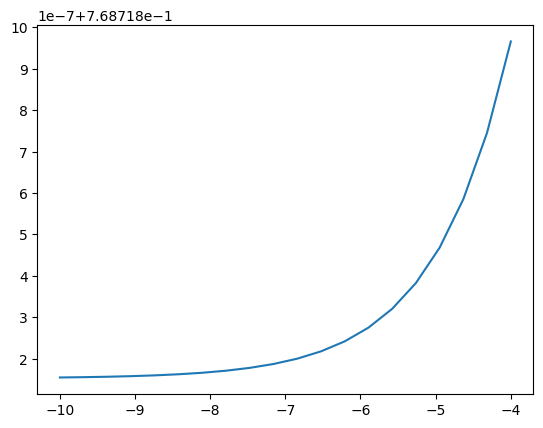

In [28]:
model.log_multihit_rate.data[0] = 0.

def loss_for_constant(rate):
    model.log_multihit_rate.data[1:] = rate
    output_probs = model(unscaled_ratess, branch_lengths)
    return criterion(output_probs.view(-1, 4), labels.view(-1)).detach().item()

rates = torch.linspace(-10, -4, 20)
losses = [loss_for_constant(rate) for rate in rates]
plt.plot(rates, losses)


In [29]:
# show entries of labels_batch that are not -1
labels_batch[labels_batch != -1].unique(return_counts=True)

NameError: name 'labels_batch' is not defined

Epoch 1/5, Loss: 0.8671
Epoch 2/5, Loss: 0.8670
Epoch 3/5, Loss: 0.8670
Epoch 4/5, Loss: 0.8669
Epoch 5/5, Loss: 0.8669


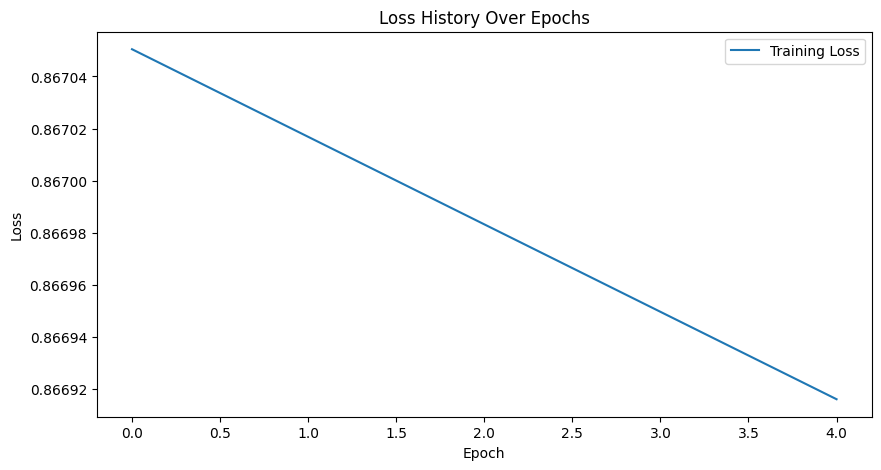

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assume 'model', 'criterion', and 'optimizer' are already defined and initialized
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Adjust learning rate as necessary

# Number of epochs to train
epochs = 5

# Lists to store loss values to plot later
loss_history = []

# Full batch training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode

    # Forward pass: compute predicted outputs by passing inputs to the model
    output_probs = model(unscaled_ratess, branch_lengths)
    loss = criterion(output_probs.view(-1, 4), labels.view(-1))

    # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record and print loss
    current_loss = loss.item()
    loss_history.append(current_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss:.4f}")

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Loss History Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
